In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import peakutils

#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = 10.5, 4

# Task 1

$\frac{dN(t)}{dt}=\frac{rN}{1-\frac{N}{K}}$

## Analytical Solution

Seperate

$\frac{dN(t)}{N(t)(1-\frac{N(t)}{K})} = r \times dt$

Partial Fraction Decomposition

$\frac{1}{N(t)(1-\frac{N(t)}{K})} = \frac{1}{N} + \frac{\frac{1}{K}}{1-\frac{N(t)}{K}}$

Substitution and Integration

$\int \frac{1}{N(t)} + \frac{\frac{1}{K}}{1-\frac{N(t)}{K}} dN \int r \times dt$

$\int r \times dt = rt + C_1$

$\int \frac{1}{N(t)} dN = \ln{N(t)} + C_2$

$\int \frac{\frac{1}{K}}{1 - \frac{N(t)}{K}} dN$ 
use $u = 1 - \frac{N(t)}{K}$ 
and $du = - \frac{1}{k} dN$

$\int \frac{-du}{u} = -\ln u + C_3 = -\ln{1 - \frac{N(t)}{K}} + C_3$

$\ln{N(t)} - \ln{1 - \frac{N(t)}{K}} = \ln{\frac{N(t)}{1-\frac{N(t)}{K}}} = rt + C$

$\frac{N(t)}{1-\frac{N(t)}{K}} = e^{rt + C} = Ae^{rt}$ 

Cross Multiply

$N(t) = Ae^{rt} \times 1 - \frac{N(t)}{K}$

$N(t) = Ae^{rt} - Ae^{rt} \times \frac{N(t)}{K}$

$N(t) + Ae^{rt} \times \frac{N(t)}{K} = N(t)\big[1 + \frac{Ae^{rt}}{K}\big] = Ae^{rt}$

$N(t) = \frac{Ae^{rt}}{1 + \frac{Ae^{rt}}{K}}$

A can be solved with initial condition at time $t=0$

$Ae^0 = A = \frac{N(0)}{1-\frac{N(0)}{K}}$

In [2]:
time_delta = .5

In [3]:
n_0 = 5
r = 3
K = 100
hours = 6
t = np.arange(0, hours, time_delta)

In [4]:
A = n_0 / (1 - n_0 / K)

def f_analytical(t):
    return A * np.exp(r * t) / (1 + A * np.exp(r * t) / K)

N_analytical = f_analytical(t)

In [5]:
# Calculate Numerical Solution

def f(n, t):
    return r * n * (1 - n / K)

N_numerical = odeint(f, n_0, t)

The numerical solution is calculated with `scipy.integrate` and the results are compared below. 

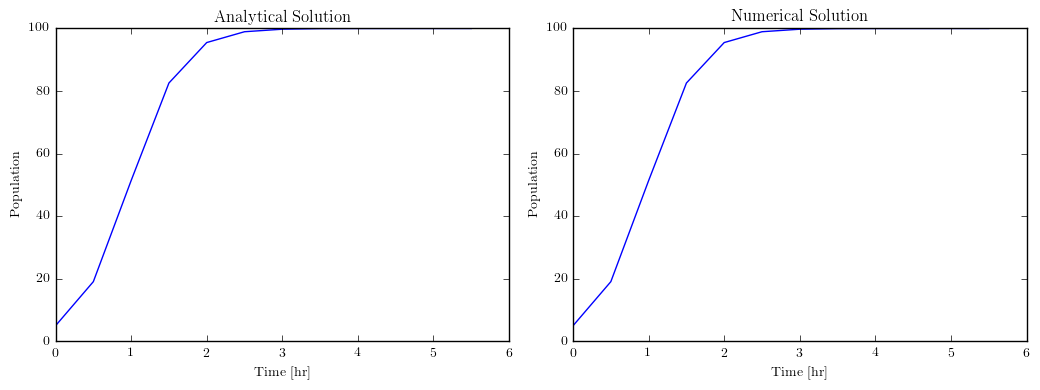

In [6]:
fig, axes = plt.subplots(1,2)

axes[0].set_title('Analytical Solution')
axes[0].set_xlabel('Time [hr]')
axes[0].set_ylabel('Population')
axes[0].plot(t, N_analytical)

axes[1].set_title('Numerical Solution')
axes[1].set_xlabel('Time [hr]')
axes[1].set_ylabel('Population')
axes[1].plot(t, N_numerical)

plt.tight_layout()
plt.show()

# Task 2

Modeling a multiple eqn system. See http://scipy.github.io/old-wiki/pages/Cookbook/Zombie_Apocalypse_ODEINT


$\frac{dM}{dt} = V_s \frac{K^n}{K^n + F_N^n} - V_m \frac{M}{K_M+M}$

$\frac{dF_C}{dt} = k_s M - V_d \frac{F_C}{K_d + F_C} - k_{in}F_C + k_{out}F_N$

$\frac{dF_N}{dt} = k_{in}F_C - k_{out}F_N$

In [7]:
hours = 24 * 25
t = np.arange(0, hours, time_delta)

In [8]:
def calc_period(peaks):
    x = []
    for i in range(1, len(peaks) - 1):
        der = peaks[i + 1] - peaks[i]
        der = der * time_delta
        x.append(der)
    return np.mean(x)

## Task 2a

Modifying the original value of $k_{in}=0.02$ to $k_{in}=0.0248$ causes the period to change from $T \approx 23.7 \text{hr}$ to $T \approx 21.5 \text{hr}$

In [9]:
V_s = 1.5
V_m = 1.5
V_d = 1.0
k_s = 0.5
K = 0.2
K_m = 0.15
K_d = 0.15
k_in = 0.0248
k_out = 0.1
n = 4

def f(y, t):
    M, F_C, F_N = y
    
    f0 = V_s * K ** n / (K ** n + F_N ** n) - V_m * M / (K_m + M)
    f1 = k_s * M - V_d * F_C / (K_d + F_C) - k_in * F_C + k_out * F_N
    f2 = k_in * F_C - k_out * F_N
    
    return [f0, f1, f2]

y_0 = M_0, F_C_0, F_N_0 = 0, 0, 0
soln = odeint(f, y_0, t)

M_soln, F_C_soln, F_N_soln = soln[:,0], soln[:,1], soln[:,2]

F_C_peaks = peakutils.indexes(F_C_soln)
F_N_peaks = peakutils.indexes(F_N_soln)
M_peaks = peakutils.indexes(M_soln)

The maximum nuclear concentration occurs at the following times [hr]:

In [10]:
print(*(F_N_peaks * time_delta), sep=', ')

18.5, 43.0, 65.0, 87.0, 108.5, 130.0, 151.5, 173.0, 194.5, 215.5, 237.0, 258.0, 279.5, 300.5, 322.0, 343.0, 364.5, 385.5, 407.0, 428.0, 449.0, 470.5, 491.5, 513.0, 534.0, 555.5, 576.5, 597.5


Below is reported the time gap [hr] following maximal nuclear concentration before maximal cytoplasm concentration:

In [11]:
print(*((F_N_peaks - F_C_peaks) * time_delta), sep=', ') 

3.0, 3.0, 3.0, 3.5, 3.0, 3.0, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5


The circadian clock is plotted with the maximum nuclear concentration in each period as a green circle. The evolution of each product over time is plotted to the right. It shows that the osciallation becomes steady very quickly.

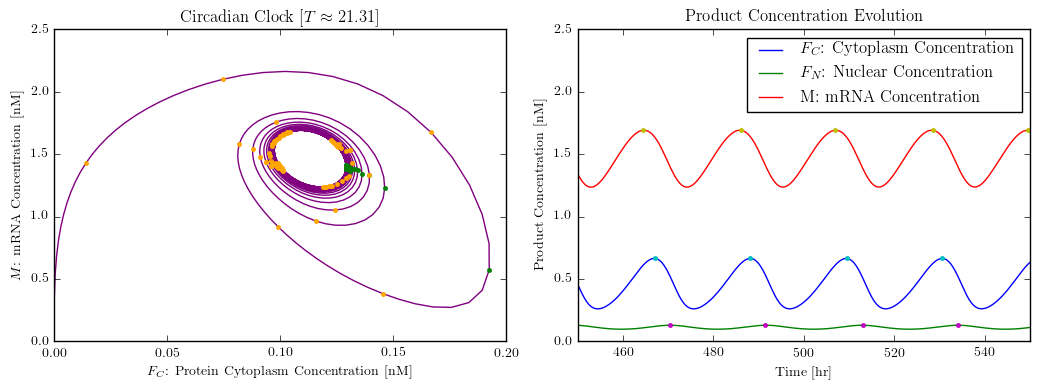

In [12]:
fig, axes = plt.subplots(1, 2)

period = calc_period(F_C_peaks)
axes[0].set_title('Circadian Clock [$T \\approx {:.2f}$]'.format(period))
axes[0].set_xlabel('$F_C$: Protein Cytoplasm Concentration [nM]')
axes[0].set_ylabel('$M$: mRNA Concentration [nM]')
axes[0].plot(F_N_soln, M_soln, c='purple')
axes[0].plot(F_N_soln[F_N_peaks], M_soln[F_N_peaks], '.', c='green')

midnight = F_N_peaks + period / time_delta / 4
morning = F_N_peaks + period / time_delta * 2 / 4
noon = F_N_peaks + period / time_delta * 3 / 4
non_eve = (np.hstack([midnight, morning, noon]) % hours / time_delta).astype(int)
axes[0].plot(F_N_soln[non_eve], M_soln[non_eve], '.', c='orange')

axes[1].set_title('Product Concentration Evolution')
axes[1].set_xlabel('Time [hr]')
axes[1].set_ylabel('Product Concentration [nM]')
axes[1].set_xlim(450, 550)
axes[1].plot(t, F_C_soln)
axes[1].plot(t, F_N_soln)
axes[1].plot(t, M_soln)
axes[1].legend(['$F_C$: Cytoplasm Concentration', '$F_N$: Nuclear Concentration', 'M: mRNA Concentration'])
axes[1].plot(F_C_peaks * time_delta, F_C_soln[F_C_peaks], '.')
axes[1].plot(F_N_peaks * time_delta, F_N_soln[F_N_peaks], '.')
axes[1].plot(M_peaks * time_delta,   M_soln[M_peaks], '.')

plt.tight_layout()
plt.show()

# Task 3

Perform simulations to show, under which conditions a 12-12 hours light-dark stimulus is able to entrain the intrensic *Neurospora* clock.

Take $step=0.5$ for the increase of transcription rate altering the mRNA production speed $V_s$ from ${V_s}_0=1.5$ during 12 hours of darkness to ${V_s}_1 = {V_s}_0 + step$ during the following 12 hours of light.

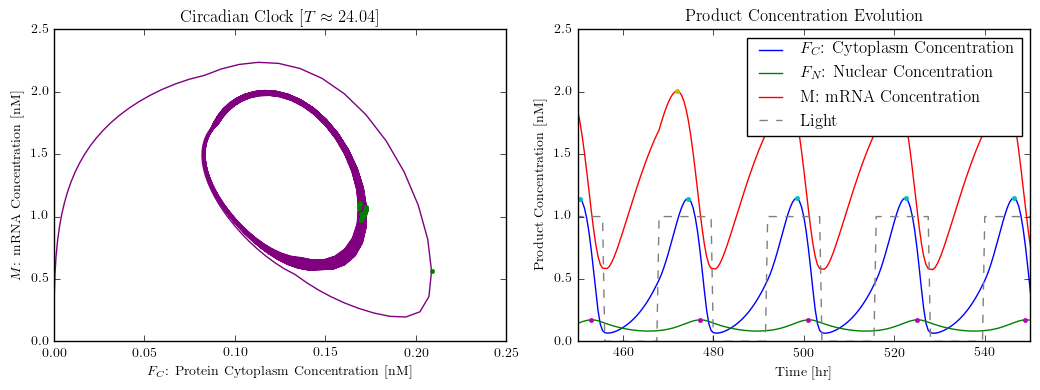

In [43]:
hours = 24 * 25
t = np.arange(0, hours, time_delta)

step = 0.06 #0.04 is interesting, 0.06 is winner
dark = 12
light = 12

V_s = 1.5
V_m = 1.5
V_d = 1.0
k_s = 0.5
K = 0.2
K_m = 0.15
K_d = 0.15
k_in = 0.0248
k_out = 0.1
n = 4

def f(y, t):
    M, F_C, F_N = y
    
    local_V_s = V_s if t % (dark + light) < dark else V_s + step
    
    f0 = local_V_s * K ** n / (K ** n + F_N ** n) - V_m * M / (K_m + M)
    f1 = k_s * M - V_d * F_C / (K_d + F_C) - k_in * F_C + k_out * F_N
    f2 = k_in * F_C - k_out * F_N
    
    return [f0, f1, f2]

y_0 = M_0, F_C_0, F_N_0 = 0, 0, 0
soln = odeint(f, y_0, t)

M_soln, F_C_soln, F_N_soln = soln[:,0], soln[:,1], soln[:,2]

F_C_peaks = peakutils.indexes(F_C_soln)
F_N_peaks = peakutils.indexes(F_N_soln)
M_peaks = peakutils.indexes(M_soln)

fig, axes = plt.subplots(1, 2)

period = calc_period(F_C_peaks)
axes[0].set_title('Circadian Clock [$T \\approx {:.2f}$]'.format(period))
axes[0].set_xlabel('$F_C$: Protein Cytoplasm Concentration [nM]')
axes[0].set_ylabel('$M$: mRNA Concentration [nM]')
axes[0].plot(F_N_soln, M_soln, c='purple')
axes[0].plot(F_N_soln[F_N_peaks], M_soln[F_N_peaks], '.', c='green')

axes[1].set_title('Product Concentration Evolution')
axes[1].set_xlabel('Time [hr]')
axes[1].set_ylabel('Product Concentration [nM]')
axes[1].set_xlim(450, 550)
axes[1].plot(t, F_C_soln)
axes[1].plot(t, F_N_soln)
axes[1].plot(t, M_soln)
axes[1].plot(t, t % (dark + light) >= dark, '--', c='grey')
axes[1].legend(['$F_C$: Cytoplasm Concentration', '$F_N$: Nuclear Concentration', 'M: mRNA Concentration', 'Light'])
axes[1].plot(F_C_peaks * time_delta, F_C_soln[F_C_peaks], '.')
axes[1].plot(F_N_peaks * time_delta, F_N_soln[F_N_peaks], '.')
axes[1].plot(M_peaks * time_delta,   M_soln[M_peaks], '.')

plt.tight_layout()
plt.show()

The tipping point is around $step=0.06$. Below this value, the clock becomes erradic and the period goes to around 21 hours. Above this value, the clock stabilizes and the period turns to 24 hours. The above graph shows the stable clock with $step=0.06$

After stabilizing, the signal seems to lock with the minimial nuclear protein concentration at the beginning of the light application and the minimal cytoplasm protein concentration at the end of the light application.

# Task 4

Perform simulations to show under which conditions a 18-6 light-dark stimulus is able to entrain the intrensic *Neurospora* clock. Modify the simulations of Task 2 using 8 hours of darkness and 18 hours of light.

In [18]:
hours = 24 * 25
t = np.arange(0, hours, time_delta)

step = 0.5
dark = 6
light = 18

V_s = 1.5
V_m = 1.5
V_d = 1.0
k_s = 0.5
K = 0.2
K_m = 0.15
K_d = 0.15
k_in = 0.0248
k_out = 0.1
n = 4

def f(y, t):
    M, F_C, F_N = y
   
    local_V_s = V_s if t % (dark + light) < dark else V_s + step
    
    f0 = local_V_s * K ** n / (K ** n + F_N ** n) - V_m * M / (K_m + M)
    f1 = k_s * M - V_d * F_C / (K_d + F_C) - k_in * F_C + k_out * F_N
    f2 = k_in * F_C - k_out * F_N
    
    return [f0, f1, f2]

y_0 = M_0, F_C_0, F_N_0 = 0, 0, 0
soln = odeint(f, y_0, t)

M_soln, F_C_soln, F_N_soln = soln[:,0], soln[:,1], soln[:,2]

F_C_peaks = peakutils.indexes(F_C_soln)
F_N_peaks = peakutils.indexes(F_N_soln)
M_peaks = peakutils.indexes(M_soln)

fig, axes = plt.subplots(1, 2)

period = calc_period(F_C_peaks)
axes[0].set_title('Circadian Clock [$T \\approx {:.2f}$]'.format(period))
axes[0].set_xlabel('$F_C$: Protein Cytoplasm Concentration [nM]')
axes[0].set_ylabel('$M$: mRNA Concentration [nM]')
axes[0].plot(F_N_soln, M_soln, c='purple')
axes[0].plot(F_N_soln[F_N_peaks], M_soln[F_N_peaks], '.', c='green')

axes[1].set_title('Product Concentration Evolution')
axes[1].set_xlabel('Time [hr]')
axes[1].set_ylabel('Product Concentration [nM]')
axes[1].set_xlim(450, 550)
axes[1].plot(t, F_C_soln)
axes[1].plot(t, F_N_soln)
axes[1].plot(t, M_soln)
axes[1].plot(t, t % (dark + light) >= dark, '--', c='grey')
axes[1].legend(['$F_C$: Cytoplasm Concentration', '$F_N$: Nuclear Concentration', 'M: mRNA Concentration', 'Light'])
axes[1].plot(F_C_peaks * time_delta, F_C_soln[F_C_peaks], '.')
axes[1].plot(F_N_peaks * time_delta, F_N_soln[F_N_peaks], '.')
axes[1].plot(M_peaks * time_delta,   M_soln[M_peaks], '.')

plt.tight_layout()
plt.show()

# Task 5

Perform simulations by changing the parameter Vs. Does the oscillation disappears above / below some specific value?

/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


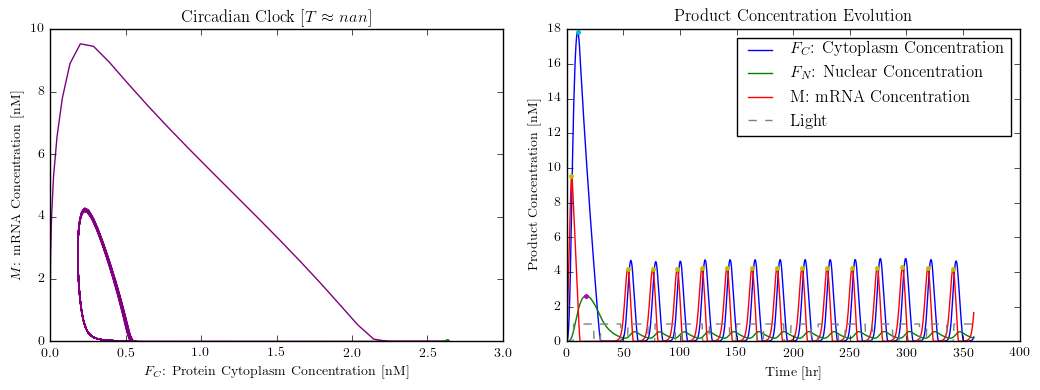

In [68]:
hours = 24 * 15
t = np.arange(0, hours, time_delta)

step = 0.06
dark = 6
light = 18

V_s = 4
V_m = 1.5
V_d = 1.0
k_s = 0.5
K = 0.2
K_m = 0.15
K_d = 0.15
k_in = 0.0248
k_out = 0.1
n = 4

def f(y, t):
    M, F_C, F_N = y
   
    local_V_s = V_s if t % (dark + light) < dark else V_s + step
    
    f0 = local_V_s * K ** n / (K ** n + F_N ** n) - V_m * M / (K_m + M)
    f1 = k_s * M - V_d * F_C / (K_d + F_C) - k_in * F_C + k_out * F_N
    f2 = k_in * F_C - k_out * F_N
    
    return [f0, f1, f2]

y_0 = M_0, F_C_0, F_N_0 = 0, 0, 0
soln = odeint(f, y_0, t)

M_soln, F_C_soln, F_N_soln = soln[:,0], soln[:,1], soln[:,2]

F_C_peaks = peakutils.indexes(F_C_soln)
F_N_peaks = peakutils.indexes(F_N_soln)
M_peaks = peakutils.indexes(M_soln)

fig, axes = plt.subplots(1, 2)

period = calc_period(F_C_peaks)
axes[0].set_title('Circadian Clock [$T \\approx {:.2f}$]'.format(period))
axes[0].set_xlabel('$F_C$: Protein Cytoplasm Concentration [nM]')
axes[0].set_ylabel('$M$: mRNA Concentration [nM]')
axes[0].plot(F_N_soln, M_soln, c='purple')
axes[0].plot(F_N_soln[F_N_peaks], M_soln[F_N_peaks], '.', c='green')

axes[1].set_title('Product Concentration Evolution')
axes[1].set_xlabel('Time [hr]')
axes[1].set_ylabel('Product Concentration [nM]')
axes[1].plot(t, F_C_soln)
axes[1].plot(t, F_N_soln)
axes[1].plot(t, M_soln)
axes[1].plot(t, t % (dark + light) >= dark, '--', c='grey')
axes[1].legend(['$F_C$: Cytoplasm Concentration', '$F_N$: Nuclear Concentration', 'M: mRNA Concentration', 'Light'])
axes[1].plot(F_C_peaks * time_delta, F_C_soln[F_C_peaks], '.')
axes[1].plot(F_N_peaks * time_delta, F_N_soln[F_N_peaks], '.')
axes[1].plot(M_peaks * time_delta,   M_soln[M_peaks], '.')

plt.tight_layout()
plt.show()

Down to values of 0.001, the oscillation stays robust, just with smaller protein concentrations. As V_s increases past 3.0, the osciallation time becomes so large and the protein concentration so high, that it is not biologically reasonable. 

# Task 6

## Task 6a

Solve the differential equation system in Task 3 for fixed points and record the positive & real solution(s) only. Note that the fixed points are given by the solution set of the vector field equated to zero. You can solve a system of equation by a computer algebra system, e.g. using SAGE or its online version, or using a homotopy solver such as Bertini (which works for much higher dimensional systems).

In [70]:
# TODO: use Bertini Python wrapper

## Task 6b

Compute the Jacobian matrix at the positive real solution and compute the corresponding eigen values. Try to understand the significance of eigenvalues and what do they signify in the current example.

$\textbf{J}=
 \begin{bmatrix}
  \frac{\partial^2 M}{\partial t \partial M} & \frac{\partial^2 M}{\partial t \partial F_C} & \frac{\partial^2M}{\partial t \partial F_N}\\
  \frac{\partial^2 F_C}{\partial t \partial M} & \frac{\partial^2 F_C}{\partial t \partial F_C} & \frac{\partial^2 F_C}{\partial t \partial F_N} \\
 \frac{\partial^2 F_N}{\partial t \partial M} & \frac{\partial^2 F_N}{\partial t \partial F_C} & \frac{\partial^2 F_N}{\partial t \partial F_N}
\end{bmatrix}=
\begin{bmatrix}
  -V_m \frac{K_m}{{(K_m + M)}^2} & 0 & V_s\frac{nK^n{F_N}^{n-1}}{{(K^n+{F_N}^n)^2}}\\
  k_s & -V_d\frac{K_d}{{(K_d + F_C)}^2} - k_{in} & k_{out} \\
 0 & k_{in} & -k_{out}
 \end{bmatrix} 
$

## Task 6c

Solve the differential equation system for the value of the Vs for which the oscillation disappears and at which oscillation appears (cf. Task 5) and compare the respective eigen values. Explain your findings!